In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime as dt

import warnings
warnings.filterwarnings('ignore') 

# Read Dataset

In [2]:
df=pd.read_csv('covid_dataset.csv',parse_dates=['Day'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             626 non-null    datetime64[ns]
 1   Lab Test        626 non-null    int64         
 2   Confirmed case  626 non-null    int64         
 3   Death Case      626 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 19.7 KB


# Checking Null

In [3]:
df.isna().sum()

df = df.dropna()
df

,Day,Lab Test,Confirmed case,Death Case
0,2020-04-04,434,9,2
1,2020-04-05,367,18,1
2,2020-04-06,468,35,3
3,2020-04-07,679,41,5
4,2020-04-08,981,54,3
...,...,...,...,...
621,2021-12-16,25203,257,3
622,2021-12-17,16310,191,2
623,2021-12-18,13991,122,4
624,2021-12-19,19332,211,1


# Dataset Characteristics and Exploratory Data Analysis 

In [4]:
df.describe()

,Lab Test,Confirmed case,Death Case
count,626.000000,626.000000,626.000000
mean,18033.835463,2526.009585,44.798722
std,9357.619008,2936.765446,54.528270
min,367.000000,9.000000,0.000000
25%,12869.500000,657.750000,14.000000
50%,15557.000000,1637.000000,30.000000
75%,20982.750000,2953.500000,44.000000
max,55284.000000,16230.000000,264.000000


In [5]:
df.sum(axis = 0, skipna = True)

Lab Test          11289181
Confirmed case     1581282
Death Case           28044
dtype: int64

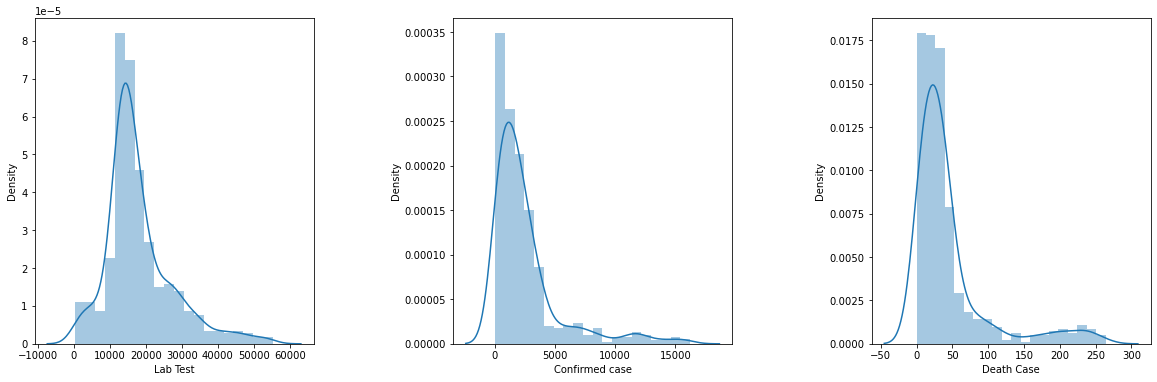

In [6]:
#Density estimation of values using distplot
plt.figure(1 , figsize = (20 , 6))

# manually add the column name of distribution plot
feature_list = ['Lab Test','Confirmed case', "Death Case"]
pos = 1 
for i in feature_list:
    plt.subplot(1 , 3 , pos)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df[i], bins=20, kde = True)
    pos = pos + 1
plt.show()

Text(0, 0.5, 'Frequency')

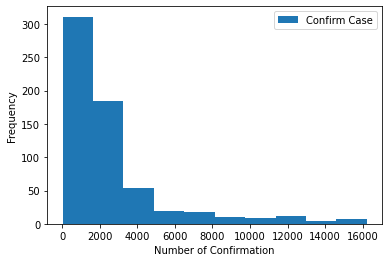

In [7]:
df['Confirmed case'].plot(legend=True,label='Confirm Case',kind ="hist")
plt.xlabel("Number of Confirmation")  
plt.ylabel("Frequency")

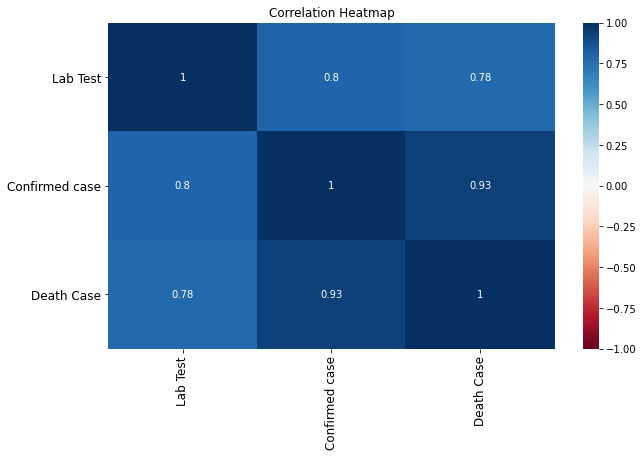

In [8]:
plt.figure(figsize = (10, 6))
s = sns.heatmap(df.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

Text(0, 0.5, 'Number of Confirmation')

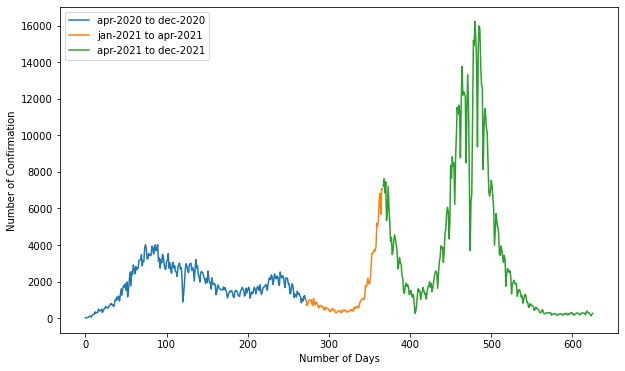

In [9]:
plt.rcParams['figure.figsize'] = (10,6)
df['Confirmed case'][:272].plot(legend=True,label='apr-2020 to dec-2020') 
df['Confirmed case'][272:367].plot(legend=True,label='jan-2021 to apr-2021')
df['Confirmed case'][367:].plot(legend=True,label='apr-2021 to dec-2021')
plt.xlabel("Number of Days")  
plt.ylabel("Number of Confirmation")

# Regression Model

In [10]:
# Regression Model

x = df.iloc[:, [0,1,3]] 
y = df.iloc[:, [2]]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

d_x_train = x_train.drop(['Day'], axis=1)
                          
d_x_test = x_test.drop(['Day'], axis=1)

lr = LinearRegression()
lr.fit(np.array(d_x_train).reshape(d_x_train.shape),np.array(y_train).reshape(y_train.shape))

y_pred = lr.predict(np.array(d_x_test).reshape(d_x_test.shape))

result = pd.DataFrame()

result['Days'] = x_test['Day']
result['Actual'] = y_test['Confirmed case']


temp = pd.DataFrame()
temp = pd.DataFrame(y_pred)

result['Predict'] = temp[0].values

In [11]:
result = result.sort_values(by = ['Days'])
result

,Days,Actual,Predict
11,2020-04-15,219,-116.294797
14,2020-04-18,306,116.944818
30,2020-05-04,688,176.390755
36,2020-05-10,887,524.533962
39,2020-05-13,1162,862.272597
...,...,...,...
611,2021-12-06,277,852.147656
613,2021-12-08,277,1009.781246
618,2021-12-13,385,964.617202
622,2021-12-17,191,605.125338


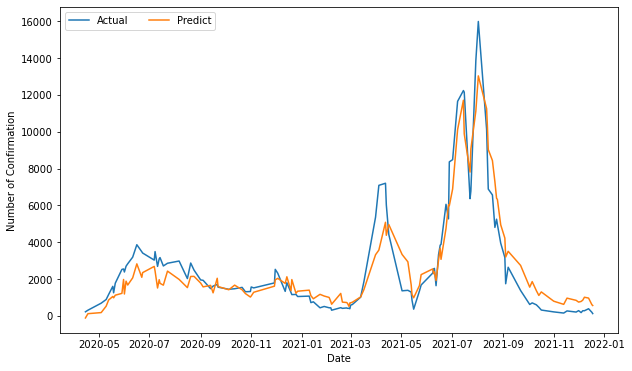

In [12]:
# Actual vs Prediction Graph
plt.figure(figsize = (10, 6))
plt.plot(result['Days'],result['Actual'])
plt.plot(result['Days'],result['Predict'])
plt.legend(['Actual','Predict'], ncol=2, loc='upper left')
plt.xlabel("Date")  
plt.ylabel("Number of Confirmation")
plt.show()

# Model coefficient

In [13]:
lr.coef_

array([[ 0.05534906, 42.50781345]])

In [14]:
lr.intercept_

array([-382.63341027])

# Score

In [15]:
print("RMSE is: ", mean_squared_error(y_test,y_pred))

print("R2 score: ",lr.score(d_x_test,y_test))

RMSE is:  1088039.2091274024
R2 score:  0.8786458121449205


In [16]:
# lr.predict(np.array([[12,3]]))

# Time Series Model

In [17]:
df = df.rename({'Lab Test': 'Lab_Test', 'Confirmed case': 'Confirmed_Case', 'Death Case': 'Death_Case'}, axis=1)

df = df.drop(['Lab_Test', 'Death_Case'], axis=1)

df=df.groupby('Day').sum()
# df.head(10)

df=df.resample(rule='W').sum()
df

,Confirmed_Case
Day,
2020-04-05,27
2020-04-12,533
2020-04-19,1835
2020-04-26,2960
2020-05-03,4039
...,...
2021-11-28,1696
2021-12-05,1659
2021-12-12,1882


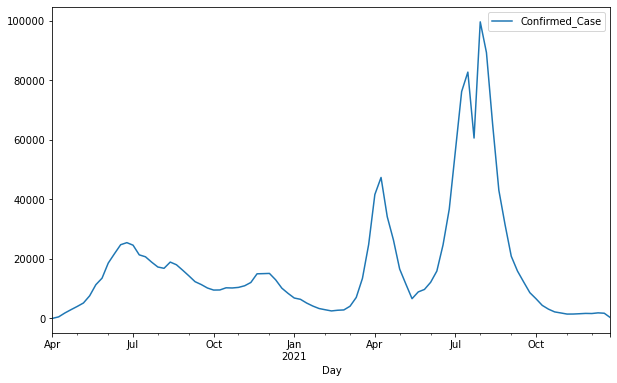

In [18]:
plt.rcParams['figure.figsize'] = (10,6)
df.plot();

# Sesonal Decompose

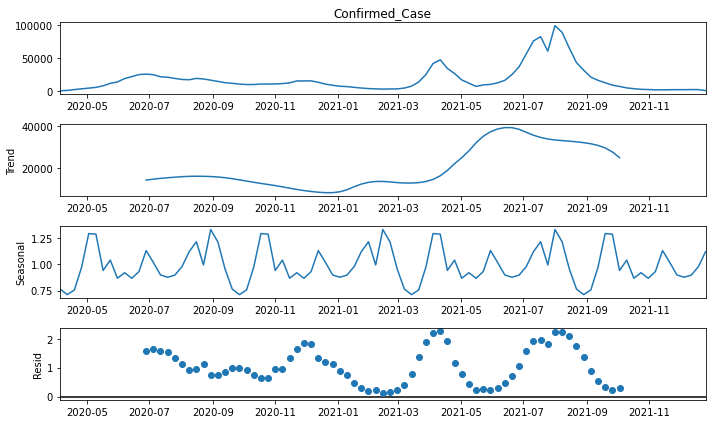

In [19]:
# seasonal_decompose(df['Confirmed_Case'],model='additive',freq=16).plot();

seasonal_decompose(df['Confirmed_Case'],model='multiplicative',freq=24).plot();

# Stationarity Check

In [20]:
afdtest = adfuller(df['Confirmed_Case'])

print('p-value of adfuller test is: ',afdtest[1])

if afdtest[1] <= 0.05:
    print('Result: Stationary')
else:
    print('Result: Not Stationary')

p-value of adfuller test is:  0.0064889803914154765
Result: Stationary


# Train test Split

In [21]:
train=df[:55]
test=df[55:] 

# Get P,D,Q values from iterations

In [22]:
p = range(0,8)
q = range(0,8)
d = range(0,2)

pdq_combinations = list(itertools.product(p,d,q))

rmse = []
order1 = []

In [23]:
count = 0
for pdq in pdq_combinations:
    count += 1
    print(count)
    pdqs = list(pdq)
    pdqs.append(24) 
    pdqs = tuple(pdqs)
    try:
        model = sm.tsa.statespace.SARIMAX(train.Confirmed_Case,order = pdq,seasonal_order = pdqs).fit()
        pred = model.predict(start = len(train), end=(len(df)-1))
        error = np.sqrt(mean_squared_error(test['Confirmed_Case'],pred))
        order1.append(pdq)
        rmse.append(error)
        
    except:
        continue

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


In [24]:
result = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])

In [25]:
result.sort_values(by='RMSE').head(20)

,RMSE
"(1, 0, 0)",27665.940072
"(0, 1, 6)",28305.391846
"(0, 1, 7)",28452.188847
"(3, 1, 6)",28476.490940
"(0, 1, 5)",28701.947680
"(2, 1, 6)",28763.654646
"(6, 1, 5)",28985.614366
"(1, 1, 7)",29707.737363
"(1, 1, 6)",29787.193306
"(5, 1, 5)",29941.512730


# ACF and PACF Test

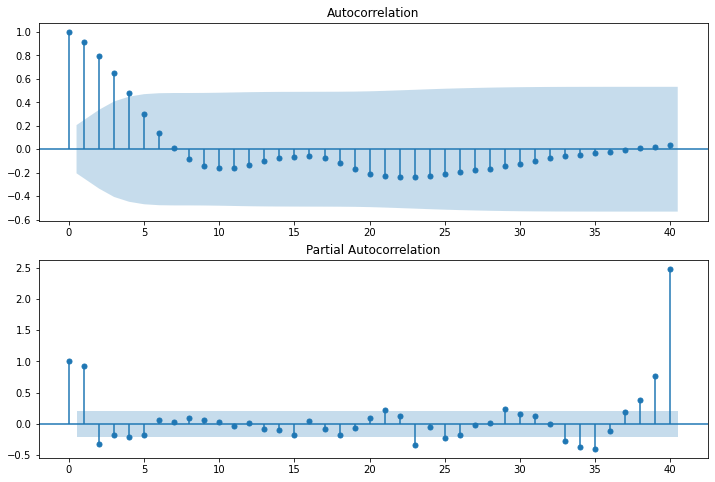

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Confirmed_Case'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Confirmed_Case'],lags=40,ax=ax2)

# Seasonal Arima Model building

In [23]:
final_model = sm.tsa.statespace.SARIMAX(train.Confirmed_Case,order=(0,1,5),seasonal_order=(0,1,5,24)).fit()

prediction = final_model.predict(start = len(df)-2, end=(len(df)+40))
prediction.head(10)

2021-12-19    16810.514145
2021-12-26    15587.335680
2022-01-02    14871.413302
2022-01-09    14412.089361
2022-01-16    13588.472324
2022-01-23    13301.795219
2022-01-30    13097.412106
2022-02-06    14544.734219
2022-02-13    17600.766550
2022-02-20    24432.191197
Freq: W-SUN, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Day'>

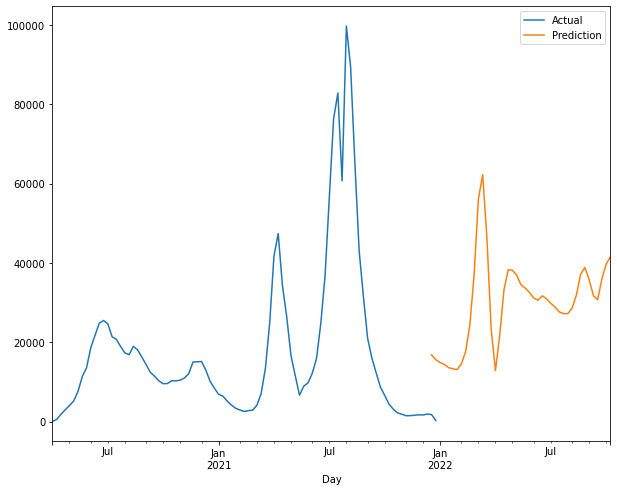

In [24]:
df['Confirmed_Case'].plot(legend=True, label='Actual', figsize=(10,8))
prediction.plot(legend=True, label='Prediction')

# New Prediction Regression

In [25]:
p_data = pd.read_csv('covid_dataset_extra.csv')

# p_data.isna().sum()

p_data = p_data.dropna()
p_data

pre_data = p_data.drop(['Day'], axis=1)

x_pre = pre_data.iloc[:, [0,2]]
y_pre = pre_data.iloc[:, [1]]

y_pred_extra = lr.predict(np.array(x_pre).reshape(x_pre.shape))

mean_squared_error(y_pre,y_pred_extra)

result_pre = pd.DataFrame()

result_pre['Days'] = p_data['Day']
result_pre['Actual'] = y_pre['Confirmed case']


temp2 = pd.DataFrame()
temp2 = pd.DataFrame(y_pred_extra)

result_pre['Predict'] = temp2[0].values

result_pre

,Days,Actual,Predict
0,2021-December-21,291,817.167839
1,2021-December-22,352,699.274347
2,2021-December-23,382,788.552114
3,2021-December-24,342,595.993006
4,2021-December-25,275,418.101137
5,2021-December-26,268,732.316947
6,2021-December-27,373,615.807969
7,2021-December-28,397,708.074847
8,2021-December-29,495,817.444584
9,2021-December-30,509,1169.518362


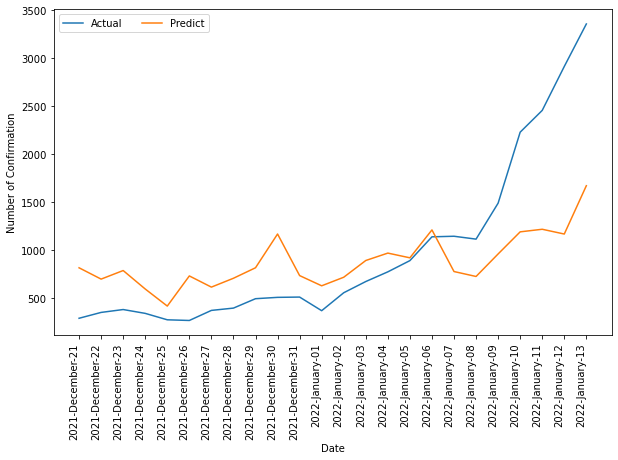

In [26]:
# Actual vs Prediction Graph

plt.plot(result_pre['Days'],result_pre['Actual'])
plt.plot(result_pre['Days'],result_pre['Predict'])
plt.xticks(np.arange(len(result_pre['Days'])), result_pre['Days'], rotation=90, horizontalalignment='right')
plt.legend(['Actual','Predict'], ncol=2, loc='upper left')
plt.xlabel("Date")  
plt.ylabel("Number of Confirmation")
plt.show()

# Comaparison Between Two Model

In [27]:
result_pre["Days"] = pd.to_datetime(result_pre["Days"])
comparison = result_pre.groupby('Days').sum()
comparison = comparison.resample(rule='W').sum()

comparison = comparison.rename({'Predict': 'Regression'}, axis=1)

comparison['SARIMA'] = prediction[1:len(comparison)+1]

In [28]:
comparison

,Actual,Regression,SARIMA
Days,,,
2021-12-26,1910,4051.405390,15587.335680
2022-01-02,3213,5394.941188,14871.413302
2022-01-09,7234,6463.175891,14412.089361
2022-01-16,10964,5252.709196,13588.472324
